In [1]:
import pandas as pd
import numpy as np
import pickle

from collections import defaultdict
import re

from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import lars_path
from sklearn.metrics import r2_score

import xgboost as xgb

# Loading features

In [2]:
with open("listings.pkl", "rb") as f:
    df_listings = pickle.load(f)

In [3]:
baseline_col = [
"price",
"bedrooms",
"beds", 
"bathrooms",  
"room_type", 
"latitude_displacement", 
"longitude_displacement", 
"distance",
"m_income", 
"station_distance",
"availability_60",
"reviews_per_month",
# "review_scores_rating", 
"sentiment",
]

df_baseline = df_listings[baseline_col]

# EDA and cleansing

In [4]:
# for i in baseline_col:
#     print(i, df_baseline[df_baseline[i].isnull()].shape)

df_baseline = df_baseline[  (~df_baseline.sentiment.isnull()) ]
# (~df_baseline.review_scores_rating.isnull()) &

In [5]:
# cleaning

df_baseline = df_baseline[ (df_baseline.price >10) & (df_baseline.price < 300) & (df_baseline.bedrooms <= 3)\
                          & (df_baseline.beds <= 4) & (df_baseline.bathrooms <= 4)\
                          &(df_baseline.room_type != "Shared room") & (df_listings.reviews_per_month > 1) ]

# log transform distance to station
df_baseline.station_distance = df_baseline.station_distance.transform(lambda x: np.log(x))

/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [6]:
# g = sns.pairplot(df_baseline, plot_kws={'alpha':0.01})

In [7]:
df_baseline.corr()

,price,bedrooms,beds,bathrooms,latitude_displacement,longitude_displacement,distance,m_income,station_distance,availability_60,reviews_per_month,sentiment
price,1.000000,0.427227,0.440516,0.211739,0.095530,0.185286,-0.374222,0.300115,-0.227768,0.119306,-0.080945,0.229494
bedrooms,0.427227,1.000000,0.686718,0.278346,-0.003126,-0.070153,0.020242,-0.056524,0.043397,0.103245,-0.032942,0.077914
beds,0.440516,0.686718,1.000000,0.229056,-0.007414,-0.000866,-0.055529,0.028895,-0.014752,0.121849,0.060709,0.085344
bathrooms,0.211739,0.278346,0.229056,1.000000,-0.120521,0.100334,0.003350,-0.067618,-0.039241,0.113107,-0.015719,0.007049
latitude_displacement,0.095530,-0.003126,-0.007414,-0.120521,1.000000,-0.487972,0.025869,0.340316,-0.209873,-0.115343,-0.003974,0.135219
longitude_displacement,0.185286,-0.070153,-0.000866,0.100334,-0.487972,1.000000,-0.365565,0.010210,-0.185698,0.041467,-0.022225,0.050541
distance,-0.374222,0.020242,-0.055529,0.003350,0.025869,-0.365565,1.000000,-0.327045,0.435897,0.016848,-0.093747,-0.144749
m_income,0.300115,-0.056524,0.028895,-0.067618,0.340316,0.010210,-0.327045,1.000000,-0.166436,-0.065337,0.018322,0.243255
station_distance,-0.227768,0.043397,-0.014752,-0.039241,-0.209873,-0.185698,0.435897,-0.166436,1.000000,-0.038201,-0.040789,-0.062964
availability_60,0.119306,0.103245,0.121849,0.113107,-0.115343,0.041467,0.016848,-0.065337,-0.038201,1.000000,-0.033019,-0.021805


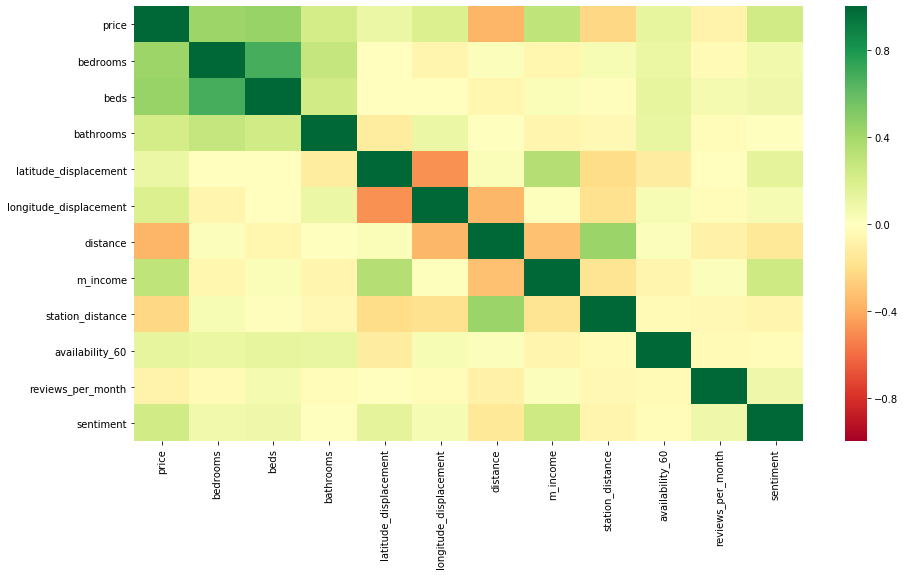

In [8]:
plt.figure(figsize=(15,8))
sns.heatmap(df_baseline.corr(), vmin=-1, vmax=1, center=0, cmap="RdYlGn" )

# Price prediction linear model

In [9]:
y = df_baseline.price
X = df_baseline.drop(columns=["price"])

# # uncomment for 4-feature baseline model

# X = df_baseline[["bedrooms", 
# "room_type", 
# "distance",
# "sentiment"]]

X = pd.get_dummies(X, columns = ["room_type"]).drop(columns="room_type_Private room")

In [10]:
for i in range(11):
    X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    X_train, X_validation, y_train, y_validation = train_test_split(X_tv, y_tv, test_size=0.25, random_state=i)

    reg = LinearRegression().fit(X_train, y_train)
    print("train set score is: {:0.3f}\nvalidation set score is: {:0.3f}"\
          .format(reg.score(X_train, y_train), reg.score(X_validation, y_validation)))

    reg = LinearRegression().fit(X_tv, y_tv)
    print("test set score is : {:0.3f}\n".format(reg.score(X_test, y_test)))

train set score is: 0.555
validation set score is: 0.541
test set score is : 0.506

train set score is: 0.545
validation set score is: 0.533
test set score is : 0.541

train set score is: 0.530
validation set score is: 0.572
test set score is : 0.556

train set score is: 0.562
validation set score is: 0.539
test set score is : 0.496

train set score is: 0.541
validation set score is: 0.541
test set score is : 0.551

train set score is: 0.549
validation set score is: 0.514
test set score is : 0.551

train set score is: 0.531
validation set score is: 0.553
test set score is : 0.572

train set score is: 0.540
validation set score is: 0.549
test set score is : 0.545

train set score is: 0.545
validation set score is: 0.550
test set score is : 0.526

train set score is: 0.548
validation set score is: 0.550
test set score is : 0.521

train set score is: 0.537
validation set score is: 0.550
test set score is : 0.556



In [11]:
# think about the features, clean data if needed

for i, j in zip(X.columns, reg.coef_ ):
    print("{} coefficient are \t {:0.3f}".format(i, j))
print("{} coefficient are \t {:0.3f}".format("intercept", reg.intercept_))

bedrooms coefficient are 	 16.155
beds coefficient are 	 3.814
bathrooms coefficient are 	 18.240
latitude_displacement coefficient are 	 1.191
longitude_displacement coefficient are 	 3.108
distance coefficient are 	 -4.891
m_income coefficient are 	 0.001
station_distance coefficient are 	 -3.596
availability_60 coefficient are 	 0.307
reviews_per_month coefficient are 	 -4.373
sentiment coefficient are 	 71.583
room_type_Entire home/apt coefficient are 	 44.464
intercept coefficient are 	 2.444


In [12]:
results = sm.OLS(y_tv, X_tv, hasconst=1).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     328.8
Date:                Tue, 17 Sep 2019   Prob (F-statistic):               0.00
Time:                        13:40:11   Log-Likelihood:                -15701.
No. Observations:                3084   AIC:                         3.143e+04
Df Residuals:                    3072   BIC:                         3.150e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
bedrooms              

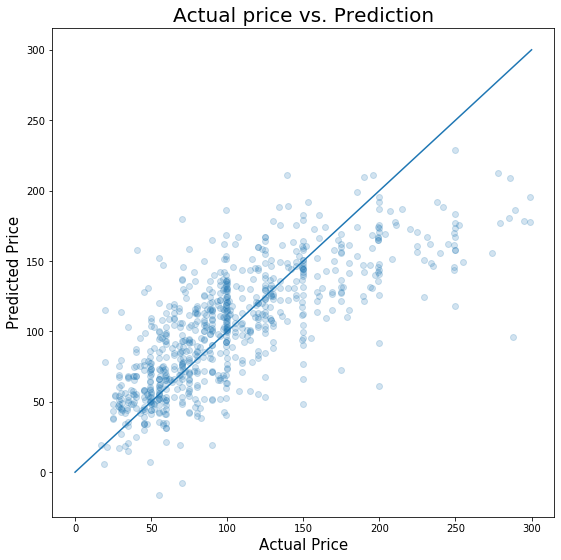

In [13]:
plt.figure(figsize=(9,9))

plt.xlabel('Actual Price', fontsize=15)
plt.ylabel('Predicted Price', fontsize=15)
plt.title('Actual price vs. Prediction', fontsize=20)

plt.scatter(y_test, results.predict(X_test), alpha=.2)

plt.plot(np.linspace(0,300,100), np.linspace(0,300,100))

Computing regularization path using the LARS ...


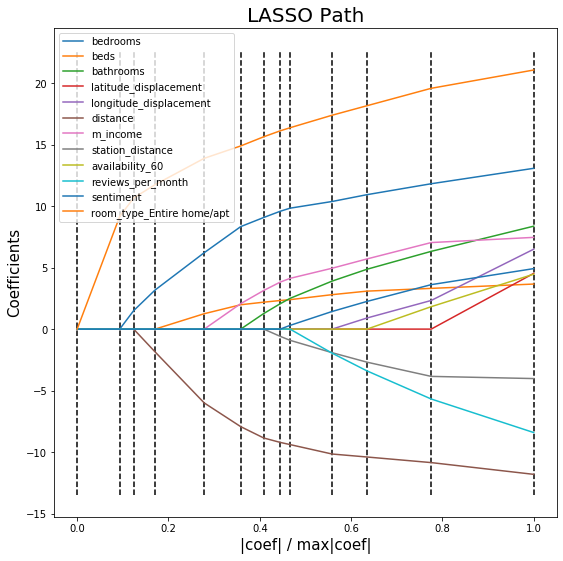

In [14]:
## Scale the variables
std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)

## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(9,9))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|', fontsize=15)
plt.ylabel('Coefficients', fontsize=15)
plt.title('LASSO Path', fontsize=20)
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

# Random forest regressor

In [15]:
for i in range(11):
    X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    X_train, X_validation, y_train, y_validation = train_test_split(X_tv, y_tv, test_size=0.25, random_state=i)

#     regr = RandomForestRegressor(max_depth=2, random_state=i, n_estimators=100)
    
    regr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
               max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, random_state=i, verbose=0, warm_start=False)    
    
    regr.fit(X_train, y_train)
    print("train set score is: {:0.3f}\nvalidation set score is: {:0.3f}"\
          .format(regr.score(X_train, y_train), regr.score(X_validation, y_validation)))

    regr.fit(X_tv, y_tv)
    print("test set score is : {:0.3f}\n".format(regr.score(X_test, y_test)))
    print(np.round(regr.feature_importances_ , decimals=3), "\n \n")

train set score is: 0.559
validation set score is: 0.483
test set score is : 0.480

[0.032 0.003 0.216 0.005 0.006 0.125 0.014 0.021 0.004 0.013 0.014 0.547] 
 

train set score is: 0.564
validation set score is: 0.472
test set score is : 0.508

[0.026 0.003 0.199 0.006 0.012 0.145 0.026 0.02  0.011 0.011 0.018 0.524] 
 

train set score is: 0.541
validation set score is: 0.505
test set score is : 0.522

[0.035 0.003 0.206 0.006 0.01  0.14  0.022 0.025 0.008 0.008 0.015 0.524] 
 

train set score is: 0.573
validation set score is: 0.487
test set score is : 0.453

[0.02  0.005 0.206 0.006 0.007 0.142 0.018 0.021 0.004 0.016 0.019 0.536] 
 

train set score is: 0.557
validation set score is: 0.463
test set score is : 0.523

[0.026 0.005 0.217 0.005 0.009 0.121 0.032 0.013 0.007 0.012 0.018 0.535] 
 

train set score is: 0.555
validation set score is: 0.473
test set score is : 0.509

[0.024 0.004 0.207 0.004 0.006 0.148 0.018 0.02  0.007 0.011 0.016 0.534] 
 

train set score is: 0.536
va

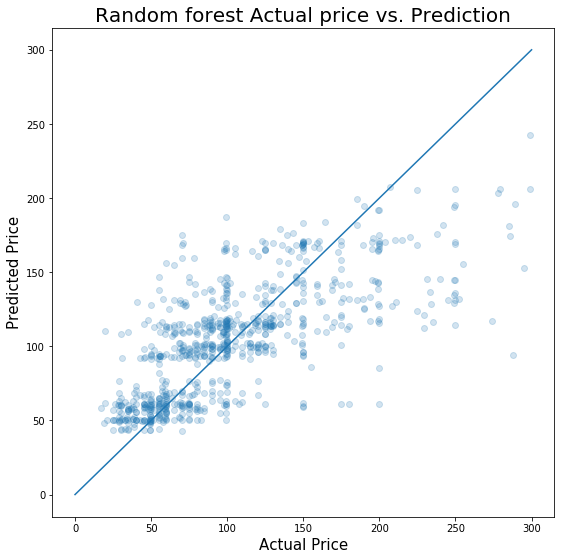

In [16]:
plt.figure(figsize=(9,9))

plt.xlabel('Actual Price', fontsize=15)
plt.ylabel('Predicted Price', fontsize=15)
plt.title('Random forest Actual price vs. Prediction', fontsize=20)

plt.scatter(y_test, regr.predict(X_test), alpha=.2)

plt.plot(np.linspace(0,300,100), np.linspace(0,300,100))

# Polynormial model

In [17]:
poly = PolynomialFeatures(2)
P = poly.fit_transform(X)

In [18]:
for i in range(11):
    P_tv, P_test, y_tv, y_test = train_test_split(P, y, test_size=0.2, random_state=i)
    P_train, P_validation, y_train, y_validation = train_test_split(P_tv, y_tv, test_size=0.25, random_state=i)

    reg = LinearRegression().fit(P_train, y_train)
    print(i, "train set score is: {:0.3f}, validation set score is: {:0.3f} \n"\
          .format(reg.score(P_train, y_train), reg.score(P_validation, y_validation)))

    reg = LinearRegression().fit(P_tv, y_tv)
    print("test set score is : {:0.3f}\n".format(reg.score(P_test, y_test)))

0 train set score is: 0.609, validation set score is: 0.576 

test set score is : 0.533

1 train set score is: 0.605, validation set score is: 0.542 

test set score is : 0.563

2 train set score is: 0.589, validation set score is: 0.588 

test set score is : 0.585

3 train set score is: 0.615, validation set score is: 0.566 

test set score is : 0.539

4 train set score is: 0.595, validation set score is: 0.566 

test set score is : 0.583

5 train set score is: 0.602, validation set score is: 0.552 

test set score is : 0.577

6 train set score is: 0.584, validation set score is: 0.579 

test set score is : 0.603

7 train set score is: 0.589, validation set score is: 0.579 

test set score is : 0.595

8 train set score is: 0.600, validation set score is: 0.576 

test set score is : 0.565

9 train set score is: 0.600, validation set score is: 0.577 

test set score is : 0.562

10 train set score is: 0.588, validation set score is: 0.578 

test set score is : 0.599



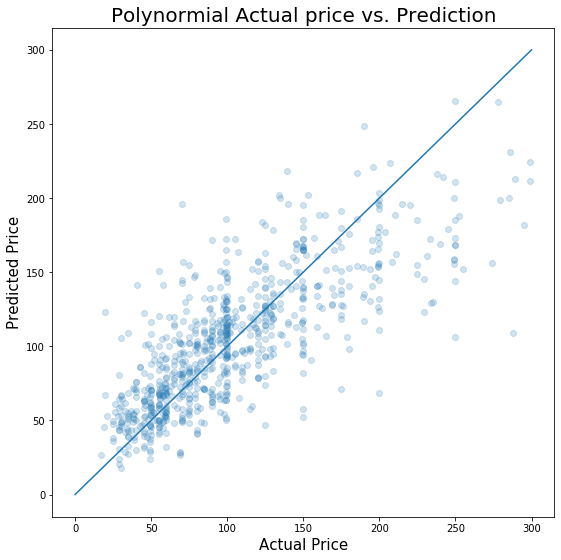

In [19]:
plt.figure(figsize=(9,9))

plt.xlabel('Actual Price', fontsize=15)
plt.ylabel('Predicted Price', fontsize=15)
plt.title('Polynormial Actual price vs. Prediction', fontsize=20)

plt.scatter(y_test, reg.predict(P_test) , alpha=.2)

plt.plot(np.linspace(0,300,100), np.linspace(0,300,100))

In [20]:
# # Scale the variables
# std = StandardScaler()
# std.fit(P_train)

# P_tr = std.transform(P_train)

# ## Note: lars_path takes numpy matrices, not pandas dataframes

# print("Computing regularization path using the LARS ...")
# alphas, _, coefs = lars_path(P_tr, y_train, method='lasso')

# # plotting the LARS path

# xx = np.sum(np.abs(coefs.T), axis=1)
# xx /= xx[-1]

# plt.figure(figsize=(9,9))
# plt.plot(xx, coefs.T)
# ymin, ymax = plt.ylim()
# plt.vlines(xx, ymin, ymax, linestyle='dashed')
# plt.xlabel('|coef| / max|coef|', fontsize=15)
# plt.ylabel('Coefficients', fontsize=15)
# plt.title('LASSO Path', fontsize=20)
# plt.axis('tight')
# # plt.legend(X_train.columns)
# plt.show()

In [21]:
r2_score(y_test, (regr.predict(X_test) + results.predict(X_test)+ reg.predict(P_test))/3, )

0.5818406977033845

# XGBoost

In [22]:
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [23]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_validation,y_validation)] #tracking train/validation error as we go

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-rmse:109.188	validation_1-rmse:109.319
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:100.091	validation_1-rmse:100.242
[2]	validation_0-rmse:92.0175	validation_1-rmse:92.3076
[3]	validation_0-rmse:84.9279	validation_1-rmse:85.2333
[4]	validation_0-rmse:78.578	validation_1-rmse:78.9405
[5]	validation_0-rmse:72.9668	validation_1-rmse:73.3709
[6]	validation_0-rmse:68.1459	validation_1-rmse:68.5386
[7]	validation_0-rmse:63.8975	validation_1-rmse:64.3625
[8]	validation_0-rmse:60.2094	validation_1-rmse:60.7053
[9]	validation_0-rmse:56.9307	validation_1-rmse:57.5593
[10]	validation_0-rmse:54.0983	validation_1-rmse:54.7238
[11]	validation_0-rmse:51.6774	validation_1-rmse:52.3551
[12]	validation_0-rmse:49.5534	validation_1-rmse:50.2781
[13]	validation_0-rmse:47.7239	validation_1-rmse:48.5053
[14]	validation_0-rmse:46.15	validation_1-rmse:46.9679

/anaconda3/envs/metis/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[49]	validation_0-rmse:35.1227	validation_1-rmse:37.485
[50]	validation_0-rmse:35.062	validation_1-rmse:37.4851
[51]	validation_0-rmse:34.9701	validation_1-rmse:37.4655
[52]	validation_0-rmse:34.8813	validation_1-rmse:37.4544
[53]	validation_0-rmse:34.8079	validation_1-rmse:37.4562
[54]	validation_0-rmse:34.7381	validation_1-rmse:37.4591
[55]	validation_0-rmse:34.6786	validation_1-rmse:37.4558
[56]	validation_0-rmse:34.6216	validation_1-rmse:37.4262
[57]	validation_0-rmse:34.5595	validation_1-rmse:37.3799
[58]	validation_0-rmse:34.488	validation_1-rmse:37.3269
[59]	validation_0-rmse:34.4308	validation_1-rmse:37.3109
[60]	validation_0-rmse:34.4037	validation_1-rmse:37.3167
[61]	validation_0-rmse:34.3522	validation_1-rmse:37.2922
[62]	validation_0-rmse:34.3174	validation_1-rmse:37.2813
[63]	validation_0-rmse:34.2699	validation_1-rmse:37.2727
[64]	validation_0-rmse:34.2124	validation_1-rmse:37.2914
[65]	validation_0-rmse:34.1642	validation_1-rmse:37.2701
[66]	validation_0-rmse:34.1404	val

In [24]:
r2_score(y_test, fit_model.predict(X_test))

0.6042744844460116

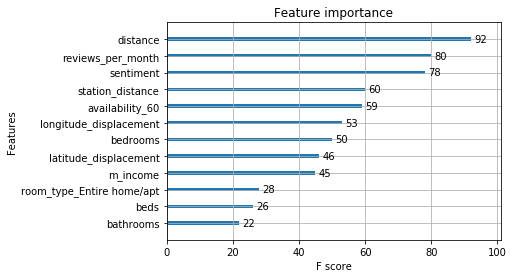

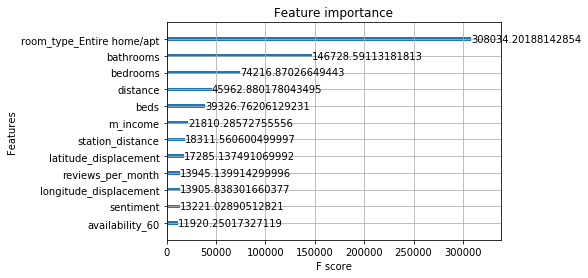

In [25]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

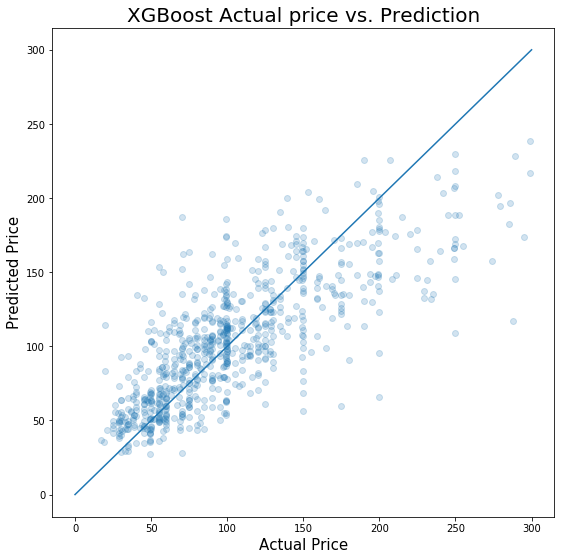

In [26]:
plt.figure(figsize=(9,9))

plt.xlabel('Actual Price', fontsize=15)
plt.ylabel('Predicted Price', fontsize=15)
plt.title('XGBoost Actual price vs. Prediction', fontsize=20)

plt.scatter(y_test, fit_model.predict(X_test), alpha=.2)

plt.plot(np.linspace(0,300,100), np.linspace(0,300,100))

# Ensenble averaging model

Text(0, 0.5, '\n\nPredicted                \n Price                ')

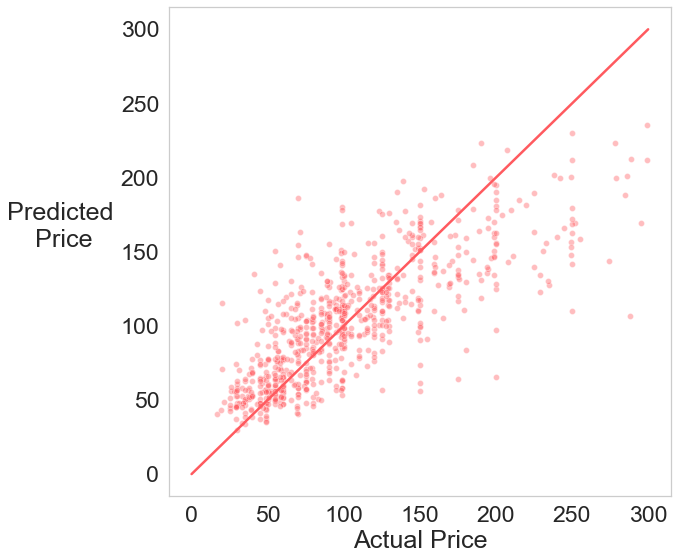

In [106]:
plt.figure(figsize=(9, 9))
sns.set(font_scale = 2.1)
sns.set_style("whitegrid", {'axes.grid' : False})
g=sns.scatterplot(y_test, (regr.predict(X_test) + reg.predict(P_test)+ fit_model.predict(X_test))/3, color = '#FF5A5F', alpha=0.4)
g=plt.plot(np.linspace(0,300,100), np.linspace(0,300,100), color = '#FF5A5F', linewidth=2.5)
plt.xlabel('Actual Price')
plt.ylabel('\n\nPredicted                \n Price                ', rotation=0)

In [62]:
r2_score(y_test, (regr.predict(X_test) + reg.predict(P_test)+ fit_model.predict(X_test))/3)

0.5915419981450014